In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Read MLBAM Data for seasons from 2014 to 2018 and appending to a new MLBAM dataframe
MLBAM14 = pd.read_csv("MLBAM14.csv")
MLBAM15 = pd.read_csv("MLBAM15.csv")
MLBAM16 = pd.read_csv("MLBAM16.csv")
MLBAM17 = pd.read_csv("MLBAM17.csv")
MLBAM18 = pd.read_csv("MLBAM18.csv")

MLBAM14.head()

#MLBAM = pd.concat([MLBAM14, MLBAM15, MLBAM16, MLBAM17, MLBAM18])

,Unnamed: 0,inning,batterId,pitcherId,event,x,y,ab_num,timestamp,stand,...,fielderId,gameId,isPA,isAB,isHit,isBIP,our.x,our.y,r,theta
0,1,1,624577,489119,Strikeout,NaN,NaN,1,2014-03-22 09:00:25,R,...,NaN,gid_2014_03_22_lanmlb_arimlb_1,True,True,False,False,NaN,NaN,NaN,NaN
1,2,1,457759,489119,Strikeout,NaN,NaN,2,2014-03-22 09:01:45,R,...,NaN,gid_2014_03_22_lanmlb_arimlb_1,True,True,False,False,NaN,NaN,NaN,NaN
2,3,1,434670,489119,Groundout,139.56,160.64,3,2014-03-22 09:03:23,R,...,431094.0,gid_2014_03_22_lanmlb_arimlb_1,True,True,False,True,36.33697,95.733939,102.398059,1.208032
3,4,1,572041,477132,Strikeout,NaN,NaN,4,2014-03-22 09:08:01,R,...,NaN,gid_2014_03_22_lanmlb_arimlb_1,True,True,False,False,NaN,NaN,NaN,NaN
4,5,1,431094,477132,Single,110.44,152.61,5,2014-03-22 09:09:10,R,...,NaN,gid_2014_03_22_lanmlb_arimlb_1,True,True,True,True,-36.33697,115.774177,121.342637,1.874920


In [3]:
# Getting the list of columns
MLBAM14.columns

Index(['Unnamed: 0', 'inning', 'batterId', 'pitcherId', 'event', 'x', 'y',
       'ab_num', 'timestamp', 'stand', 'throws', 'runnerMovement', 'half',
       'balls', 'strikes', 'endOuts', 'actionId', 'description', 'game_type',
       'home_team', 'home_teamId', 'home_lg', 'away_team', 'away_teamId',
       'away_lg', 'venueId', 'stadium', 'field_teamId', 'playerId.1B',
       'playerId.2B', 'playerId.3B', 'playerId.C', 'playerId.CF',
       'playerId.LF', 'playerId.RF', 'playerId.SS', 'batterPos', 'batterName',
       'pitcherName', 'runsOnPlay', 'startOuts', 'runsInInning', 'runsITD',
       'runsFuture', 'start1B', 'start2B', 'start3B', 'end1B', 'end2B',
       'end3B', 'outsInInning', 'startCode', 'endCode', 'fielderId', 'gameId',
       'isPA', 'isAB', 'isHit', 'isBIP', 'our.x', 'our.y', 'r', 'theta'],
      dtype='object')

In [4]:
# Function to obtain Running Expectancy dataframe for different seasons
def Run_Expectancy(df):
    
    RE = df.copy()
    
    # Dropping unnecessary column
    RE.drop(['Unnamed: 0'], axis=1, inplace=True)
    
    # Keeping only required columns
    RE = RE[['home_team','away_team','half','gameId','batterName','batterId','event', 'start1B', 'start2B', 'start3B',\
             'end1B', 'end2B', 'end3B', 'startOuts','endOuts','runsFuture','runsOnPlay','outsInInning','venueId','batterPos']]
    
    # Adding columns represent that whether a player is on the first, second and third base before the event realized
    RE['Start1'] = np.where(pd.isnull(RE['start1B']),0,1)
    RE['Start2'] = np.where(pd.isnull(RE['start2B']),0,1)
    RE['Start3'] = np.where(pd.isnull(RE['start3B']),0,1)
    
    # Creating a column represents the runners on the bases (first three digit) and number of outs before the event realized
    RE['Start_State'] = (RE['Start1'].astype(str) + RE['Start2'].astype(str) + RE['Start3'].astype(str)+\
                          " " + RE['startOuts'].astype(str))
    
    # Adding columns represent that whether a player is on the first, second and third base after the event realized    
    RE['End1'] = np.where(pd.isnull(RE['end1B']),0,1)
    RE['End2'] = np.where(pd.isnull(RE['end2B']),0,1)
    RE['End3'] = np.where(pd.isnull(RE['end3B']),0,1)
    
    # Creating a column represents the runners on the bases (first three digit) and number of outs after the event realized
    RE['End_State'] = (RE['End1'].astype(str) + RE['End2'].astype(str) + RE['End3'].astype(str) + \
                        " " + RE['endOuts'].astype(str))

    RE = RE[((RE.Start_State != RE.End_State) | (RE.runsOnPlay > 0)) & (RE.outsInInning == 3)]
    
    # Calculate runs for each state
    Start_RunExp = RE.groupby(['Start_State'])['runsFuture'].mean().reset_index().rename(columns={'runsFuture':'Start_RE'})
    
    # Merging the dataframes
    RE = pd.merge(RE, Start_RunExp, on=['Start_State'], how='left')
    
    # Create series of observations for base state when there are 3 outs which have runnign expectancy values of 0
    Base_State_3 = [pd.Series(['000 3', 0], index=Start_RunExp.columns),
                pd.Series(['001 3', 0], index=Start_RunExp.columns),
                pd.Series(['010 3', 0], index=Start_RunExp.columns),
                pd.Series(['011 3', 0], index=Start_RunExp.columns),
                pd.Series(['100 3', 0], index=Start_RunExp.columns),
                pd.Series(['101 3', 0], index=Start_RunExp.columns),
                pd.Series(['110 3', 0], index=Start_RunExp.columns),
                pd.Series(['111 3', 0], index=Start_RunExp.columns)]
    
    # Adding the states with 3 outs to start_run df
    Start_RunExp = Start_RunExp.append(Base_State_3, ignore_index=True)
    End_RunExp  = Start_RunExp.rename(columns={'Start_State':'End_State', 'Start_RE':'End_RE'})
    
    # Merge the dfs to obtain end state run expectancy
    RE = pd.merge(RE, End_RunExp, on=['End_State'], how='left')
    
    # Calculate Run Value of each event.
    RE['Run_Value'] = RE['runsOnPlay'] + RE['End_RE'] - RE['Start_RE']
    
    # Assigning team to each event
    RE['team']= np.where(RE['half']=='top',RE['away_team'],RE['home_team'])
    
    return RE;

In [5]:
# Obtaining Run Expectancy values for each season from 2014 to 2018
RE14 = Run_Expectancy(MLBAM14)   
RE15 = Run_Expectancy(MLBAM15)  
RE16 = Run_Expectancy(MLBAM16)  
RE17 = Run_Expectancy(MLBAM17)  
RE18 = Run_Expectancy(MLBAM18)  
RE14.head()

,home_team,away_team,half,gameId,batterName,batterId,event,start1B,start2B,start3B,...,Start3,Start_State,End1,End2,End3,End_State,Start_RE,End_RE,Run_Value,team
0,ari,lan,top,gid_2014_03_22_lanmlb_arimlb_1,Puig,624577,Strikeout,NaN,NaN,NaN,...,0,000 0,0,0,0,000 1,0.447272,0.232980,-0.214292,lan
1,ari,lan,top,gid_2014_03_22_lanmlb_arimlb_1,"Turner, J",457759,Strikeout,NaN,NaN,NaN,...,0,000 1,0,0,0,000 2,0.232980,0.086470,-0.146510,lan
2,ari,lan,top,gid_2014_03_22_lanmlb_arimlb_1,"Ramirez, H",434670,Groundout,NaN,NaN,NaN,...,0,000 2,0,0,0,000 3,0.086470,0.000000,-0.086470,lan
3,ari,lan,bottom,gid_2014_03_22_lanmlb_arimlb_1,Pollock,572041,Strikeout,NaN,NaN,NaN,...,0,000 0,0,0,0,000 1,0.447272,0.232980,-0.214292,ari
4,ari,lan,bottom,gid_2014_03_22_lanmlb_arimlb_1,"Hill, A",431094,Single,NaN,NaN,NaN,...,0,000 1,1,0,0,100 1,0.232980,0.477127,0.244147,ari


In [6]:
# Calculating number of events for each seasons
Event14 = RE14.groupby(['event'])['Run_Value'].count().reset_index().rename(columns = {"Run_Value": '2014'})
Event15 = RE15.groupby(['event'])['Run_Value'].count().reset_index().rename(columns = {"Run_Value": '2015'})
Event16 = RE16.groupby(['event'])['Run_Value'].count().reset_index().rename(columns = {"Run_Value": '2016'})
Event17 = RE17.groupby(['event'])['Run_Value'].count().reset_index().rename(columns = {"Run_Value": '2017'})
Event18 = RE18.groupby(['event'])['Run_Value'].count().reset_index().rename(columns = {"Run_Value": '2018'})

Events = pd.merge(Event14,Event15,on = 'event')
Events = pd.merge(Events,Event16,on = 'event')
Events = pd.merge(Events,Event17,on = 'event')
Events = pd.merge(Events,Event18,on = 'event')
Events['All Seasons'] = Events['2014'] + Events['2015'] + Events['2016'] + Events['2017'] + Events['2018']
Events

,event,2014,2015,2016,2017,2018,All Seasons
0,Batter Interference,43,39,38,35,44,199
1,Bunt Groundout,396,347,333,280,292,1648
2,Bunt Lineout,16,17,9,14,11,67
3,Bunt Pop Out,167,158,139,131,134,729
4,Catcher Interference,22,32,38,43,39,174
5,Double,8042,8159,8150,8291,8191,40833
6,Double Play,463,479,447,423,460,2272
7,Fan interference,52,43,44,44,33,216
8,Field Error,1576,1635,1590,1571,1563,7935
9,Fielders Choice,102,107,96,91,93,489


In [7]:
# Calculating the event occurences shares for different seasons
Events['2014(%)'] = Events['2014'] / Events['2014'].sum()
Events['2015(%)'] = Events['2015'] / Events['2015'].sum()
Events['2016(%)'] = Events['2016'] / Events['2016'].sum()
Events['2017(%)'] = Events['2017'] / Events['2017'].sum()
Events['2018(%)'] = Events['2018'] / Events['2018'].sum()
Events['All Seasons(%)'] = Events['All Seasons'] / Events['All Seasons'].sum()

Events[['event','2014(%)','2015(%)','2016(%)','2017(%)','2018(%)','All Seasons(%)']].sort_values(by = 'All Seasons(%)',ascending = False)

#Events.sort_values(by = 'All Seasons(%)',ascending = False)

,event,2014(%),2015(%),2016(%),2017(%),2018(%),All Seasons(%)
25,Strikeout,0.202919,0.203152,0.210507,0.215717,0.221727,0.210824
14,Groundout,0.190708,0.191590,0.184452,0.179106,0.175698,0.184294
24,Single,0.153473,0.151479,0.148367,0.144340,0.141386,0.147797
11,Flyout,0.119927,0.108755,0.110480,0.106971,0.110766,0.111374
29,Walk,0.070520,0.071012,0.076280,0.079756,0.079244,0.075373
18,Lineout,0.056808,0.063609,0.058300,0.060785,0.060828,0.060067
19,Pop Out,0.046589,0.045211,0.046326,0.046825,0.048165,0.046625
5,Double,0.043759,0.044411,0.044257,0.044877,0.044288,0.044319
16,Home Run,0.022413,0.026405,0.030062,0.032563,0.029619,0.028220
12,Forceout,0.020470,0.021571,0.020966,0.019702,0.019503,0.020441


In [8]:
# Calculating event values for each seasons
EventValue14= RE14.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV14'})
EventValue15= RE15.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV15'})
EventValue16= RE16.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV16'})
EventValue17= RE17.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV17'})
EventValue18= RE18.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV18'})

EventValues = pd.merge(EventValue14,EventValue15,on = 'event')
EventValues = pd.merge(EventValues,EventValue16,on = 'event')
EventValues = pd.merge(EventValues,EventValue17,on = 'event')
EventValues = pd.merge(EventValues,EventValue18,on = 'event')
EventValues.sort_values(by ='RV18',ascending = False)

,event,RV14,RV15,RV16,RV17,RV18
16,Home Run,1.397934,1.387911,1.382476,1.378739,1.379867
27,Triple,1.065651,1.026352,1.023911,1.063607,1.111033
5,Double,0.737518,0.752039,0.743467,0.779338,0.769674
9,Fielders Choice,0.698076,0.719351,0.701447,0.764112,0.686499
7,Fan interference,0.633560,0.577453,0.533316,0.590743,0.615308
8,Field Error,0.462976,0.485460,0.469989,0.493206,0.491236
24,Single,0.438810,0.443085,0.440258,0.455773,0.450161
15,Hit By Pitch,0.312109,0.330517,0.320569,0.338679,0.326091
29,Walk,0.297689,0.314145,0.299404,0.322635,0.315230
4,Catcher Interference,0.380337,0.318276,0.301623,0.399070,0.301083


In [9]:
# Calculating event values for each seasons for every player
PlayerValue14= RE14.groupby('batterName')['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV14'})
PlayerValue15= RE15.groupby('batterName')['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV15'})
PlayerValue16= RE16.groupby('batterName')['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV16'})
PlayerValue17= RE17.groupby('batterName')['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV17'})
PlayerValue18= RE18.groupby('batterName')['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV18'})

PlayerValues = pd.merge(PlayerValue14,PlayerValue15,on = ['batterName'],how='outer')
PlayerValues = pd.merge(PlayerValues,PlayerValue16,on = ['batterName'],how='outer')
PlayerValues = pd.merge(PlayerValues,PlayerValue17,on = ['batterName'],how='outer')
PlayerValues = pd.merge(PlayerValues,PlayerValue18,on = ['batterName'],how='outer')
PlayerValues.sort_values(by='RV18',ascending = False)

# Calculating the average Running Expectancy Value for Players 
PlayerValues['AVG'] = (PlayerValues['RV14'] + PlayerValues['RV15'] + PlayerValues['RV16'] + PlayerValues['RV17'] + PlayerValues['RV18']) / 5
PlayerValues.sort_values(by = 'AVG',ascending = False).head(10)

,batterName,RV14,RV15,RV16,RV17,RV18,AVG
908,Trout,58.296362,53.842647,68.143360,50.431739,62.286430,58.600108
330,Goldschmidt,35.129225,62.502569,36.197730,56.078941,43.334644,46.648622
939,Votto,12.156622,68.834621,45.883627,67.650742,31.613827,45.227888
26,Arenado,13.368143,45.057659,48.979171,56.111576,42.742499,41.251810
751,Rizzo,30.301643,56.752034,43.080606,37.865377,31.710874,39.942107
552,"Martinez, J",31.718140,30.987421,23.124182,34.223665,75.124792,39.035640
385,Harper,3.335534,68.860490,30.806830,37.730864,45.635485,37.273840
70,Betts,8.729840,34.452700,36.363718,25.043520,65.724469,34.062849
234,Donaldson,25.712941,56.260937,48.510824,32.587402,3.438318,33.302084
294,Freeman,24.370400,30.411682,45.551348,24.477837,40.538518,33.069957


In [10]:
# Calculating Running Expectancy values for Each Team for Different Seasons
TeamValue14= RE14.groupby('team')['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV14'})
TeamValue15= RE15.groupby('team')['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV15'})
TeamValue16= RE16.groupby('team')['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV16'})
TeamValue17= RE17.groupby('team')['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV17'})
TeamValue18= RE18.groupby('team')['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV18'})

TeamValues = pd.merge(TeamValue14,TeamValue15,on = ['team'],how='outer')
TeamValues = pd.merge(TeamValues,TeamValue16,on = ['team'],how='outer')
TeamValues = pd.merge(TeamValues,TeamValue17,on = ['team'],how='outer')
TeamValues = pd.merge(TeamValues,TeamValue18,on = ['team'],how='outer')
TeamValues.sort_values(by='RV18',ascending = False)
TeamValues.sort_values(by='team',ascending = True)

,team,RV14,RV15,RV16,RV17,RV18
0,ana,104.641532,-25.056067,-3.184209,-47.579782,2.883725
1,ari,-48.253012,31.924551,15.870968,62.616716,-31.464530
2,atl,-81.885752,-108.464134,-84.633901,-28.259905,28.955984
3,bal,46.586965,29.882644,29.297940,-23.678031,-100.435626
4,bos,-37.383914,65.372953,160.812546,9.445347,162.347595
5,cha,-1.307578,-79.136738,-41.643638,-47.416033,-68.493434
6,chn,-54.987532,-3.627047,85.327151,71.002092,22.114956
7,cin,-57.227567,-61.401274,-17.643638,5.420218,-29.493434
8,cle,-3.725729,-4.178644,48.815791,73.780465,93.927080
9,col,92.456063,47.127799,122.825528,78.616716,58.405402


In [11]:
# Winnign Shares of Teams From Season 2014 to 2018
WinPCT = pd.read_csv('WinPCTs.csv')
WinPCT

,TeamName,team,WinPCT14,WinPCT15,WinPCT16,WinPCT17,WinPCT18
0,Arizona Diamondbacks,ari,0.395,0.488,0.426,0.574,0.506
1,Atlanta Braves,atl,0.488,0.414,0.422,0.444,0.556
2,Baltimore Orioles,bal,0.593,0.500,0.549,0.463,0.290
3,Boston Red Sox,bos,0.438,0.481,0.574,0.574,0.667
4,Chicago Cubs,chn,0.451,0.599,0.640,0.568,0.583
5,Chicago White Sox,cha,0.451,0.469,0.481,0.414,0.383
6,Cincinnati Reds,cin,0.469,0.395,0.420,0.420,0.414
7,Cleveland Indians,cle,0.525,0.503,0.584,0.630,0.562
8,Colorado Rockies,col,0.407,0.420,0.463,0.537,0.558
9,Detroit Tigers,det,0.556,0.460,0.534,0.395,0.395


In [12]:
# Merging Winning Share and Running Expectancy dataframes of Teams 
TeamValues = pd.merge(WinPCT,TeamValues,on = 'team')
TeamValues.drop(['team'], axis=1, inplace=True)
TeamValues

,TeamName,WinPCT14,WinPCT15,WinPCT16,WinPCT17,WinPCT18,RV14,RV15,RV16,RV17,RV18
0,Arizona Diamondbacks,0.395,0.488,0.426,0.574,0.506,-48.253012,31.924551,15.870968,62.616716,-31.464530
1,Atlanta Braves,0.488,0.414,0.422,0.444,0.556,-81.885752,-108.464134,-84.633901,-28.259905,28.955984
2,Baltimore Orioles,0.593,0.500,0.549,0.463,0.290,46.586965,29.882644,29.297940,-23.678031,-100.435626
3,Boston Red Sox,0.438,0.481,0.574,0.574,0.667,-37.383914,65.372953,160.812546,9.445347,162.347595
4,Chicago Cubs,0.451,0.599,0.640,0.568,0.583,-54.987532,-3.627047,85.327151,71.002092,22.114956
5,Chicago White Sox,0.451,0.469,0.481,0.414,0.383,-1.307578,-79.136738,-41.643638,-47.416033,-68.493434
6,Cincinnati Reds,0.469,0.395,0.420,0.420,0.414,-57.227567,-61.401274,-17.643638,5.420218,-29.493434
7,Cleveland Indians,0.525,0.503,0.584,0.630,0.562,-3.725729,-4.178644,48.815791,73.780465,93.927080
8,Colorado Rockies,0.407,0.420,0.463,0.537,0.558,92.456063,47.127799,122.825528,78.616716,58.405402
9,Detroit Tigers,0.556,0.460,0.534,0.395,0.395,104.034237,-3.565758,30.327151,-14.997908,-89.087372


<AxesSubplot:xlabel='RV18', ylabel='WinPCT18'>

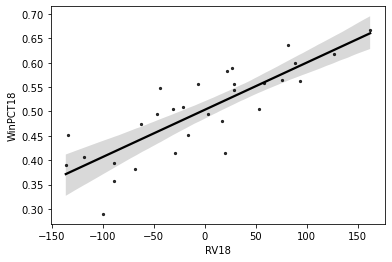

In [13]:
# Regression Line of Running Expectancy and Winning Percentage of Teams in Season 2018
sns.regplot(x="RV18", y="WinPCT18", color= 'black', fit_reg= True ,scatter_kws={'s':5},data= TeamValues)

In [14]:
# Correlation Matrix of Running Expectancy and Winning Percentage of Teams for Different Seasons
TeamCorr = TeamValues.corr()
TeamCorr = TeamCorr[['RV14','RV15','RV16','RV17','RV18']]
TeamCorr = pd.DataFrame(TeamCorr, index = ['WinPCT14','WinPCT15','WinPCT16','WinPCT17','WinPCT18'])
TeamCorr

,RV14,RV15,RV16,RV17,RV18
WinPCT14,0.427143,-0.045309,-0.097203,-0.314742,-0.103401
WinPCT15,0.131921,0.414856,0.283911,0.066663,0.087024
WinPCT16,0.098902,0.388243,0.559888,0.249861,0.183061
WinPCT17,0.059556,0.293081,0.428717,0.716524,0.710074
WinPCT18,-0.109457,0.072696,0.226500,0.438591,0.825696
